In [1]:
import json as json
import matplotlib.pyplot as plt
import os
import numpy as np

import multifil
import treatment_definitions as td
import graphing_utilities as gutil

# List valid things that can be changed
print("valid constant (phenotype) parameters\n", multifil.hs.hs.VALID_PARAMS)

imported myosin multifil
valid constant (phenotype) parameters
 ['mf_k', 'mh_c_ks', 'mh_c_kw', 'mh_c_rs', 'mh_c_rw', 'mh_g_ks', 'mh_g_kw', 'mh_g_rs', 'mh_g_rw', 'detachment_rate', 'mh_fd_k0', 'mh_fd_delta', 'mh_iso', 'af_k', 'ti_a', 'ti_b']


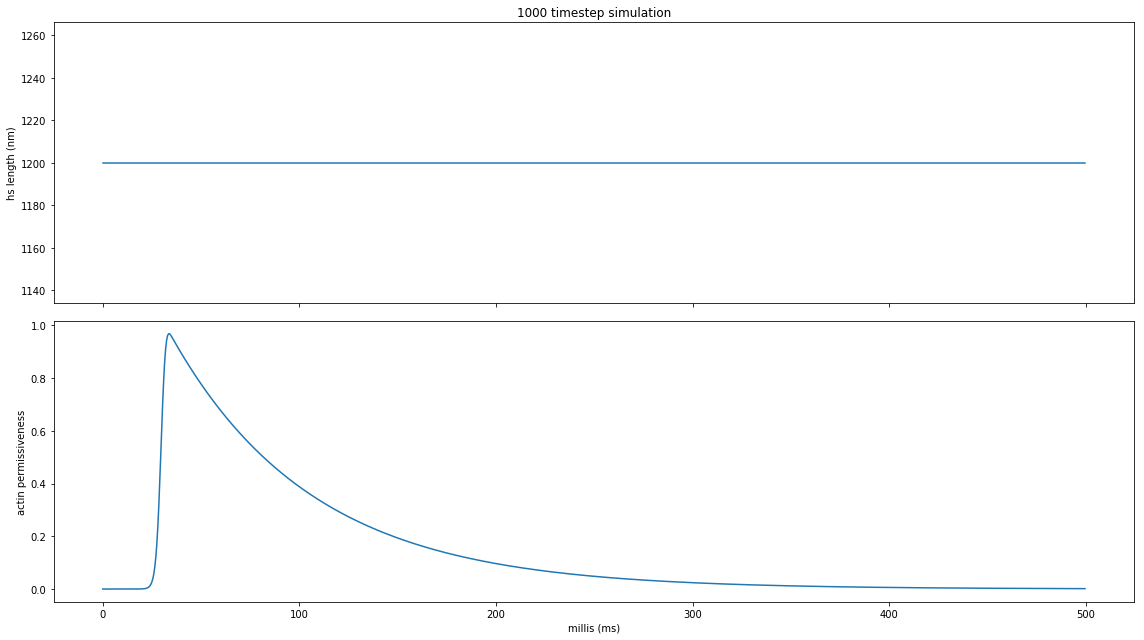

{'mh_c_ks': 40, 'mh_c_kw': 40}


In [2]:
# Setup experiment, show the traces
time_trace, length_trace, actin_permissiveness_trace, params = td.t_spring()

#plot the traces
gutil.plot_input_traces(time_trace, length_trace, actin_permissiveness_trace)

#print the phenotype settings
print(params)

In [3]:
output_dir = "../_output/"
os.makedirs(output_dir, exist_ok=True)
batch_size = 5

"""Here's the simulation loop"""
for stiffness in [20, 60, 80, 100]:
    # establish the settings
    time_trace, length_trace, actin_permissiveness_trace, params = td.t_spring(stiffness=stiffness)
    
    meta_files = []
    # create the metafiles
    for i in range(batch_size):
        wl_meta = multifil.aws.metas.emit(output_dir, # local dir to save run output to
                                          None, #s3 bucket to upload results to
                                          time_trace, 
                                          0.5, # poisson ratio, set to const vol here
                                         None, # intial ls, using default by passing none
                                         length_trace, 
                                         actin_permissiveness_trace, 
                                         str(stiffness), # comment describing run
                                         True, # whether to write out resulting file 
                                          #or just pass back to variable
                                         params)
        # find where it went
        run_name = wl_meta['name']
        print(run_name)
        run_file = output_dir + run_name + ".meta.json"
        
        # add it to the list
        meta_files.append(run_file)
    
    # give the manager_async the metafile
    run_manager = multifil.aws.run.manage_async(meta_files, False) # have run.py create the sarc from meta
    # Begin running
    run_manager.run_and_save()   # with our new sarc, run it

5d08e426-696b-11ea-b012-185680feb82e
5d09cdf8-696b-11ea-8be1-185680feb82e
5d0acbda-696b-11ea-860d-185680feb82e
5d0b9014-696b-11ea-b67b-185680feb82e
5d0cc48c-696b-11ea-bc02-185680feb82e


KeyboardInterrupt: 

In [ ]:
for run_file in meta_files:
    data_name = run_file.split('.meta')[0] + '.data.json'

    with open(data_name, 'r') as file:
        data = json.load(file)

#     for key in data.keys():
#         print(key, end=", ")

    print()
    print()
    # print_constants(data['constants'])

    key = "axial_force"
    fs = 16

    # recreate time trace in milliseconds
    time_trace = data['timestep'].copy()
    for i in range(len(time_trace)):
        time_trace[i] *= data['timestep_length']

    # plot
    fig, axes = plt.subplots(figsize=(16, 9))
    axes.plot(time_trace, data[key], color='black')

    title = "multifilament model of muscle contraction\n" + wl_meta['comment']
    plt.title(title, fontsize=fs*1.5)
    plt.xlabel("time (ms)", fontsize=fs)
    plt.ylabel(key, fontsize=fs)

    ax2 = plt.twinx()
    ax2.plot(time_trace, data['actin_permissiveness'])

    save = True # OI! make sure you know whats going on here in this statement
    if save:
        plt.savefig(output_dir + str(run_name) + ".png")
    plt.show()